In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

In [2]:
# Load the data
traffic_data = pd.read_csv("./datasets/traffic1.csv", sep=";")

traffic_data.head()

,DateTime,Junction,Vehicles
0,01/01/2019 00:00,1,14
1,01/01/2019 01:00,1,13
2,01/01/2019 02:00,1,15
3,01/01/2019 03:00,1,15
4,01/01/2019 04:00,1,15


In [3]:
Datetime_stats = traffic_data['DateTime'].describe()

Datetime_stats

count               569736
unique               43824
top       01/01/2019 00:00
freq                    14
Name: DateTime, dtype: object

In [4]:
# Convert 'DateTime' to datetime object
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

missing_values = traffic_data.isnull().sum()

duplicates = traffic_data.duplicated().sum()

# Summary statistics for the 'Vehicles' column
vehicles_stats = traffic_data['Vehicles'].describe()
Datetime_stats = traffic_data['DateTime'].describe()


missing_values, duplicates, vehicles_stats, Datetime_stats

(DateTime    0
 Junction    0
 Vehicles    0
 dtype: int64,
 4967,
 count    569736.000000
 mean         34.888385
 std          15.006353
 min           0.000000
 25%          22.000000
 50%          34.000000
 75%          48.000000
 max          70.000000
 Name: Vehicles, dtype: float64,
 count                  569736
 unique                  43824
 top       2019-01-01 00:00:00
 freq                       14
 first     2019-01-01 00:00:00
 last      2023-12-31 23:00:00
 Name: DateTime, dtype: object)

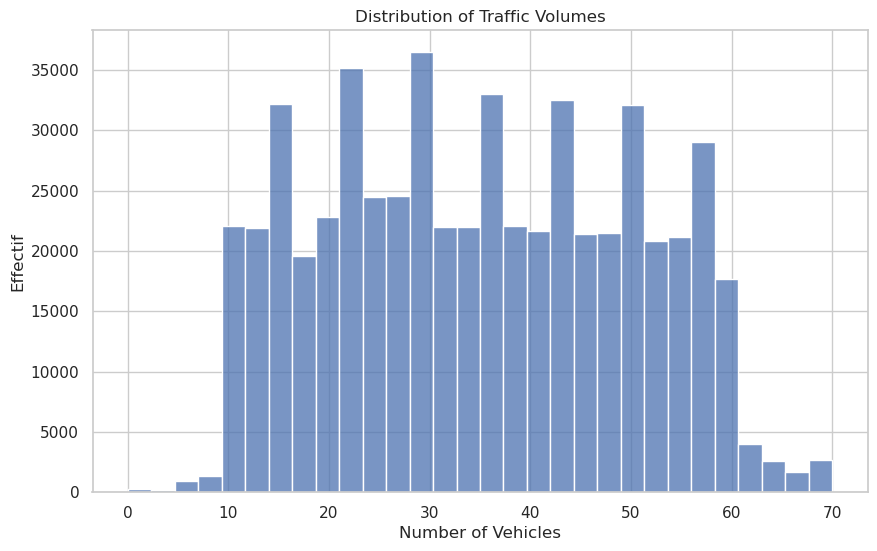

In [5]:
# Set the style of seaborn

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(traffic_data['Vehicles'], kde=False, bins=30)
plt.title('Distribution of Traffic Volumes')
plt.xlabel('Number of Vehicles')
plt.ylabel('Effectif')
plt.show()

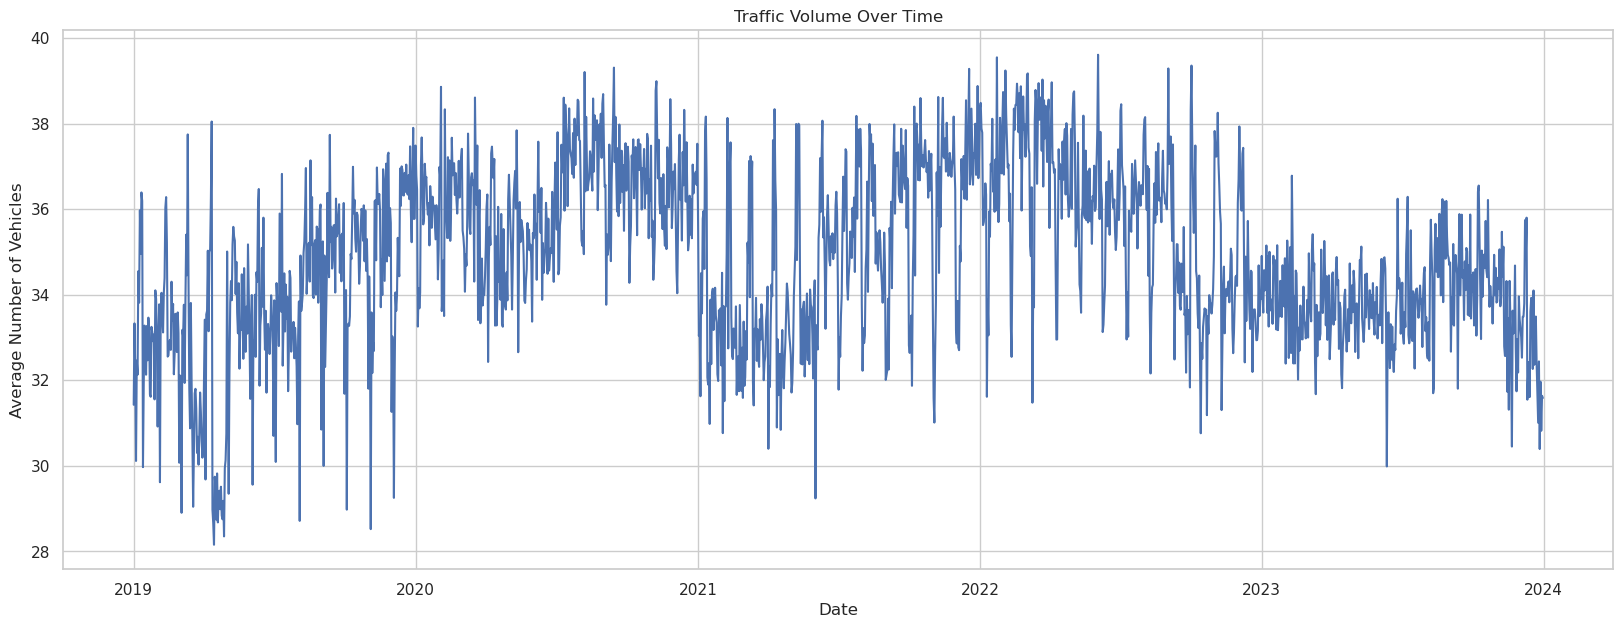

In [6]:
plt.figure(figsize=(20, 7))
traffic_data_resampled = traffic_data.set_index('DateTime').resample('D').mean()
traffic_data_resampled
sns.lineplot(data=traffic_data_resampled, x=traffic_data_resampled.index, y='Vehicles')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Vehicles')
plt.show()

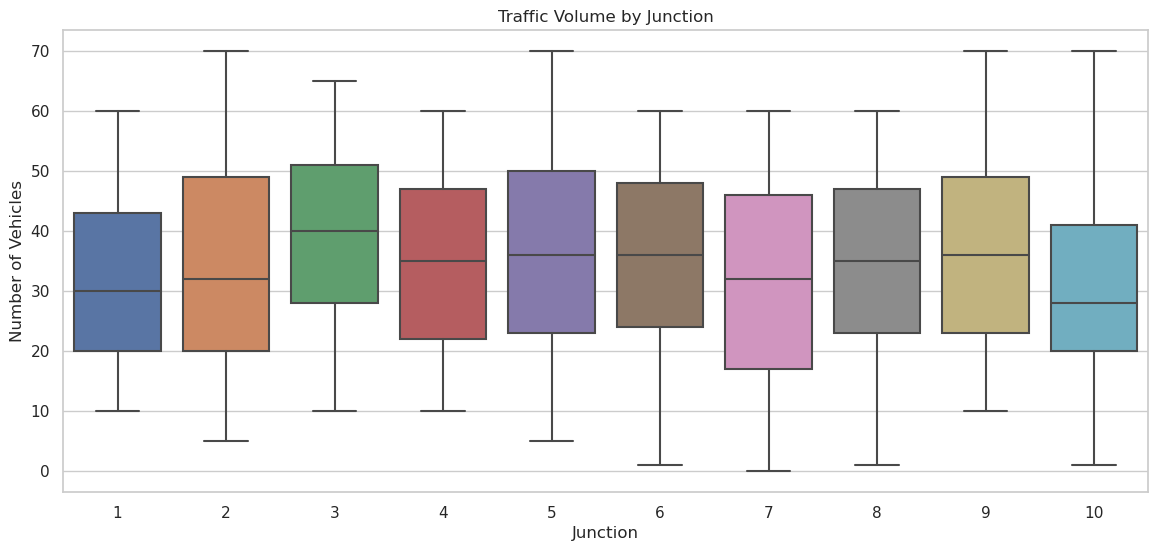

In [7]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Junction', y='Vehicles', data=traffic_data)
plt.title('Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Number of Vehicles')
plt.show()

In [8]:
# Create new columns for hour of the day and day of the week

traffic_data['HourOfDay'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.day_name()

In [9]:
# Aggregate data to find mean traffic volume for each hour of the day
# données cumulé pour obtenir le volume de Traffic moyen pour chaque heure de la journée 

hourly_traffic = traffic_data.groupby('HourOfDay')['Vehicles'].mean().reset_index()
hourly_traffic

# Aggregate data to find mean traffic volume for each day of the week

weekly_traffic = traffic_data.groupby('DayOfWeek')['Vehicles'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()
weekly_traffic

,DayOfWeek,Vehicles
0,Monday,34.949827
1,Tuesday,34.861385
2,Wednesday,34.954637
3,Thursday,34.834426
4,Friday,34.921665
5,Saturday,34.849285
6,Sunday,34.847713


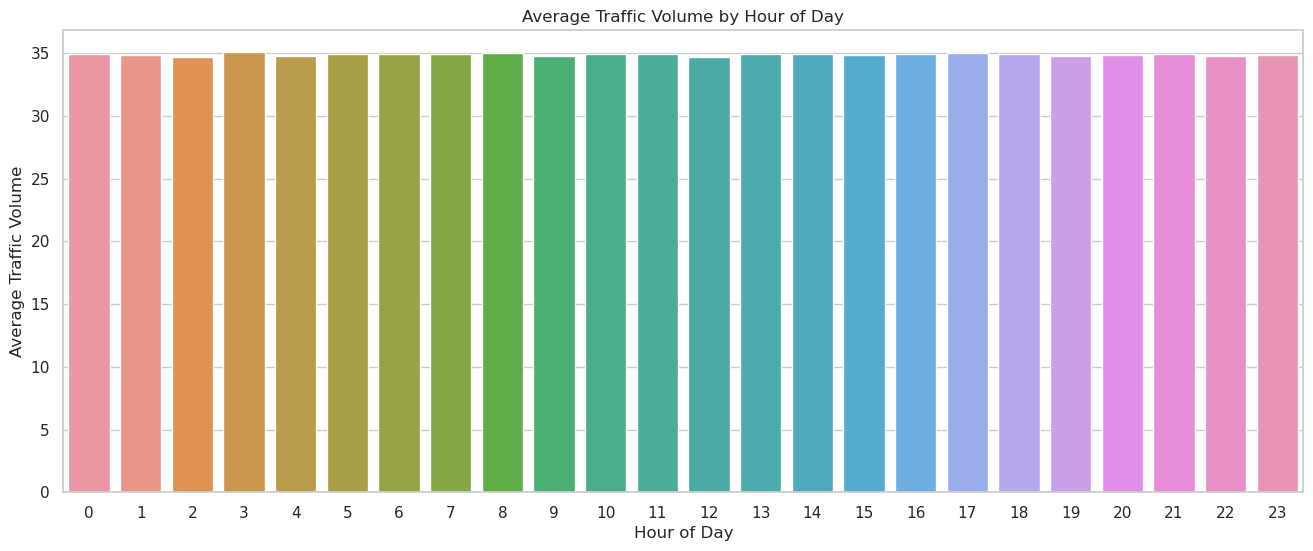

In [10]:
# Plotting the hourly traffic volume

plt.figure(figsize=(16, 6))
sns.barplot(x='HourOfDay', y='Vehicles', data=hourly_traffic)
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.xticks(np.arange(0, 24, 1))
plt.show()

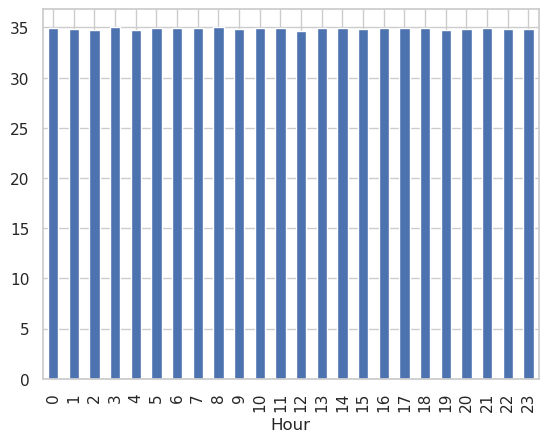

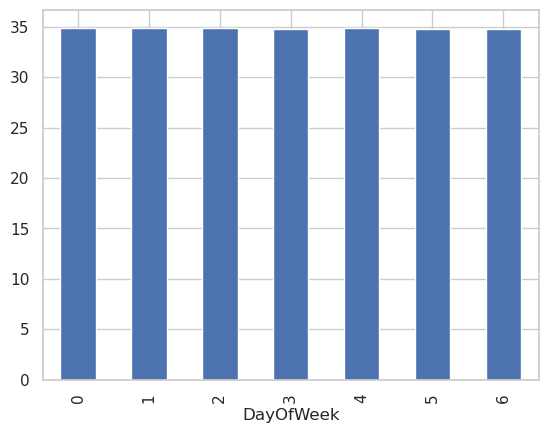

In [11]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['Hour'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek

# Peak Hour Analysis

avg_traffic_by_hour = traffic_data.groupby('Hour')['Vehicles'].mean()
avg_traffic_by_hour.plot(kind='bar')
plt.show()

# Day of the Week Analysis

avg_traffic_by_day = traffic_data.groupby('DayOfWeek')['Vehicles'].mean()
avg_traffic_by_day.plot(kind='bar')
plt.show()

<Figure size 1200x800 with 0 Axes>

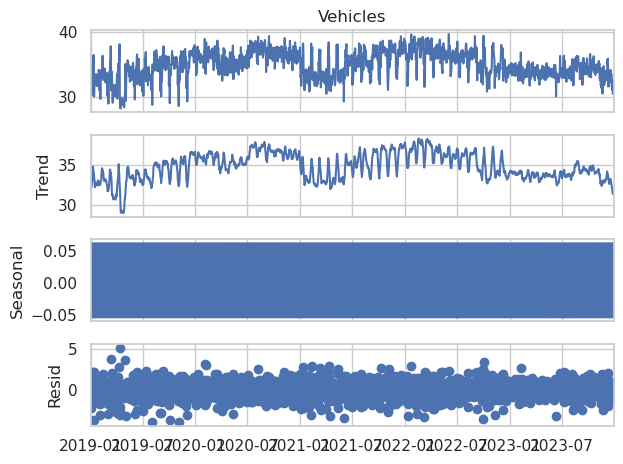

In [12]:
# Décomposition des séries temporelles 

plt.figure(figsize=(12, 8))
traffic_data_daily = traffic_data.set_index('DateTime').resample('D').mean()
decomposition = seasonal_decompose(traffic_data_daily['Vehicles'], model='additive')   # Un objet avec des attributs de saison, de tendance et de résidu.
decomposition.plot()
plt.show()

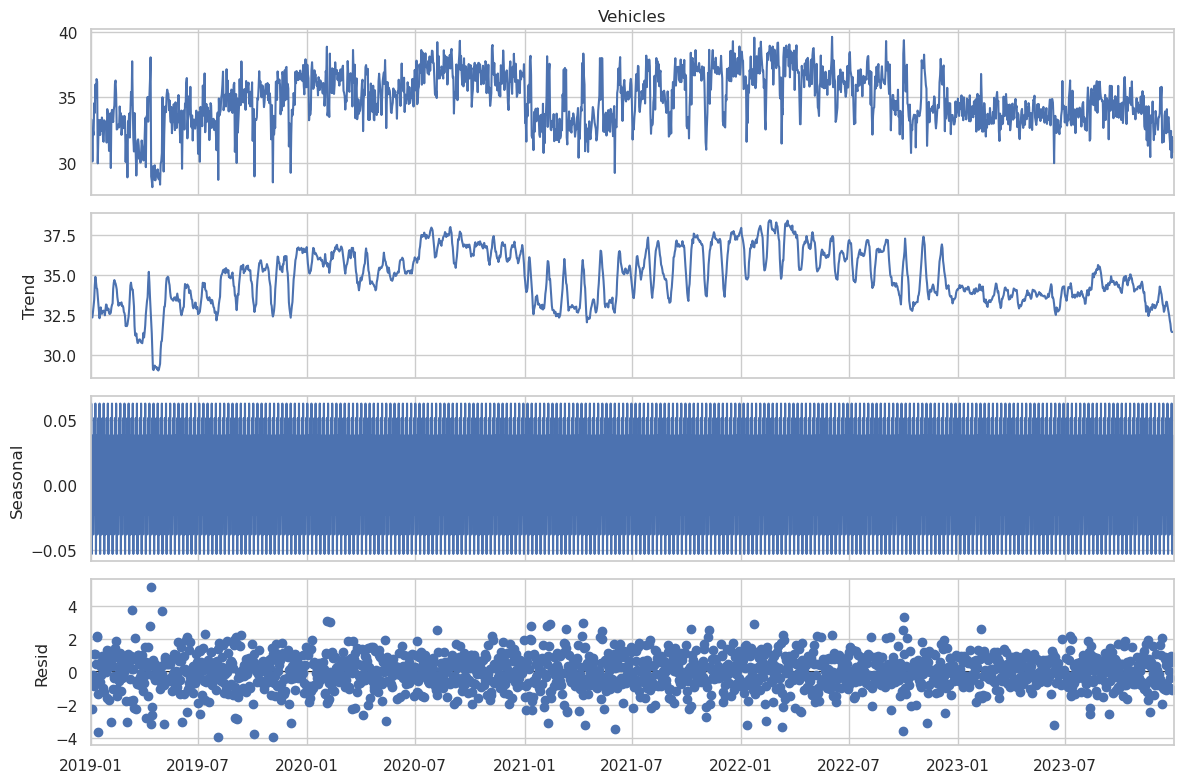

In [13]:
traffic_data = pd.read_csv('./datasets/traffic1.csv', sep= ";")


traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data.set_index('DateTime', inplace=True)

# Resample the data to get daily averages
daily_traffic = traffic_data.resample('D').mean()

# Perform the seasonal decomposition
result = seasonal_decompose(daily_traffic['Vehicles'], model='additive', period=7)


plt.rcParams['figure.figsize'] = [12, 8]

result.plot()
plt.tight_layout()
plt.show()

In [14]:
traffic_data = pd.read_csv('./datasets/traffic1.csv', sep=";")

# Convert 'DateTime' to datetime and create new time-related features
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['HourOfDay'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek  # Monday=0, Sunday=6

# Calculate the correlation matrix
correlation_matrix = traffic_data[['HourOfDay', 'DayOfWeek', 'Vehicles']].corr()

print(correlation_matrix)

              HourOfDay     DayOfWeek  Vehicles
HourOfDay  1.000000e+00  7.223084e-18 -0.000793
DayOfWeek  7.223084e-18  1.000000e+00 -0.001728
Vehicles  -7.929991e-04 -1.728317e-03  1.000000


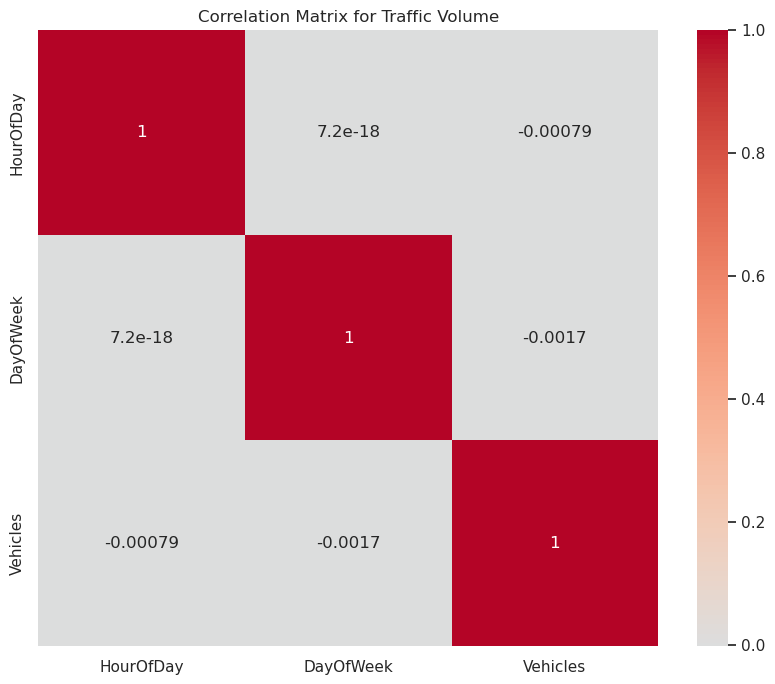

In [15]:
# mesurer la force de la relation linéaire entre deux variables

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Traffic Volume')
plt.show()

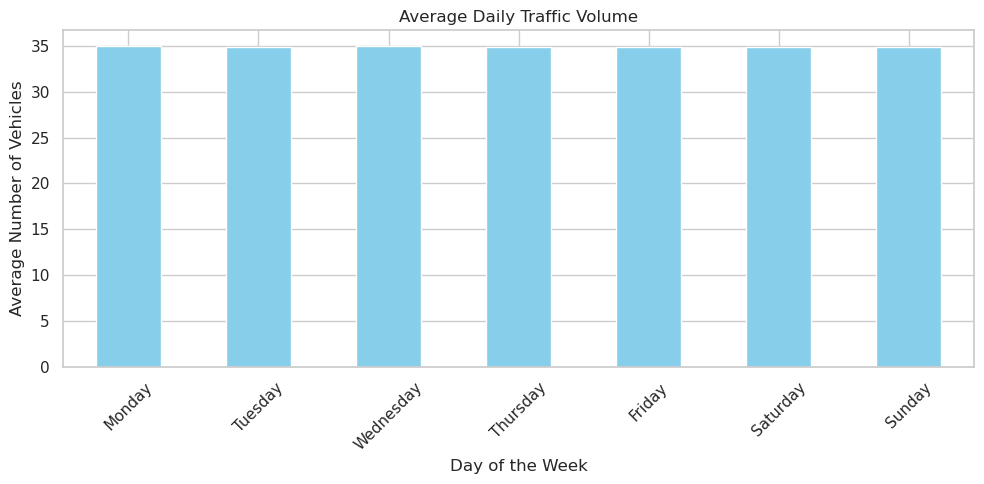

In [16]:
traffic_data = pd.read_csv('./datasets/traffic1.csv', sep=";")

traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Extract the day of the week from 'DateTime' (Monday=0, Sunday=6)
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek

# Group by 'DayOfWeek' and calculate the mean number of vehicles
average_traffic_by_day = traffic_data.groupby('DayOfWeek')['Vehicles'].mean()

# Create a mapping from day numbers to names for better readability
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
average_traffic_by_day.index = average_traffic_by_day.index.map(day_names)


plt.figure(figsize=(10, 5))
average_traffic_by_day.plot(kind='bar', color='skyblue')
plt.title('Average Daily Traffic Volume')
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Vehicles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

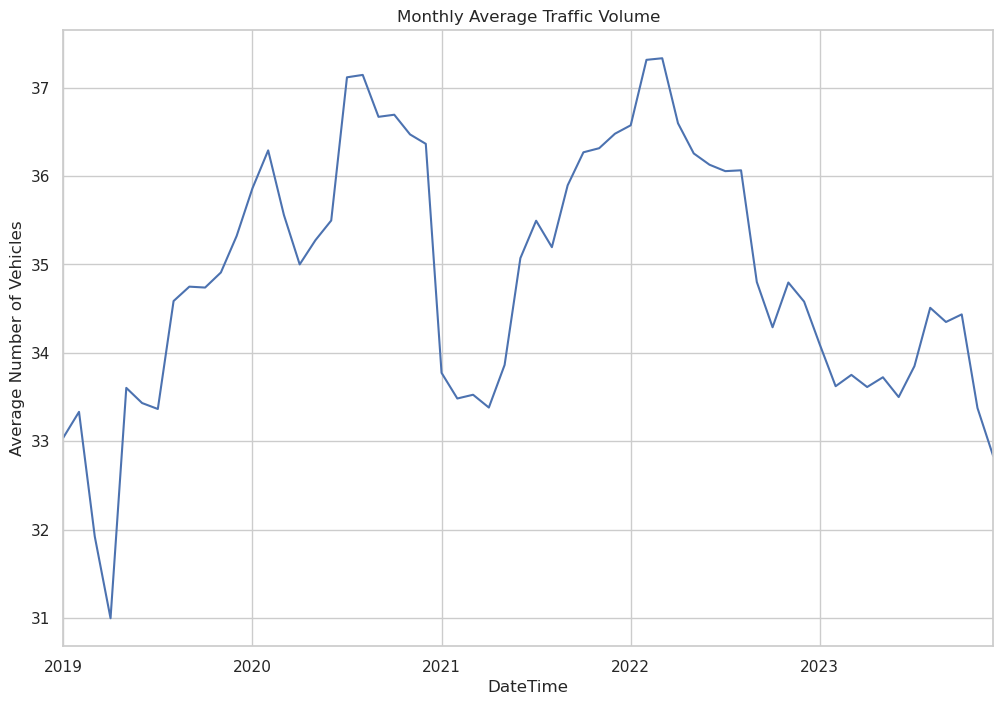

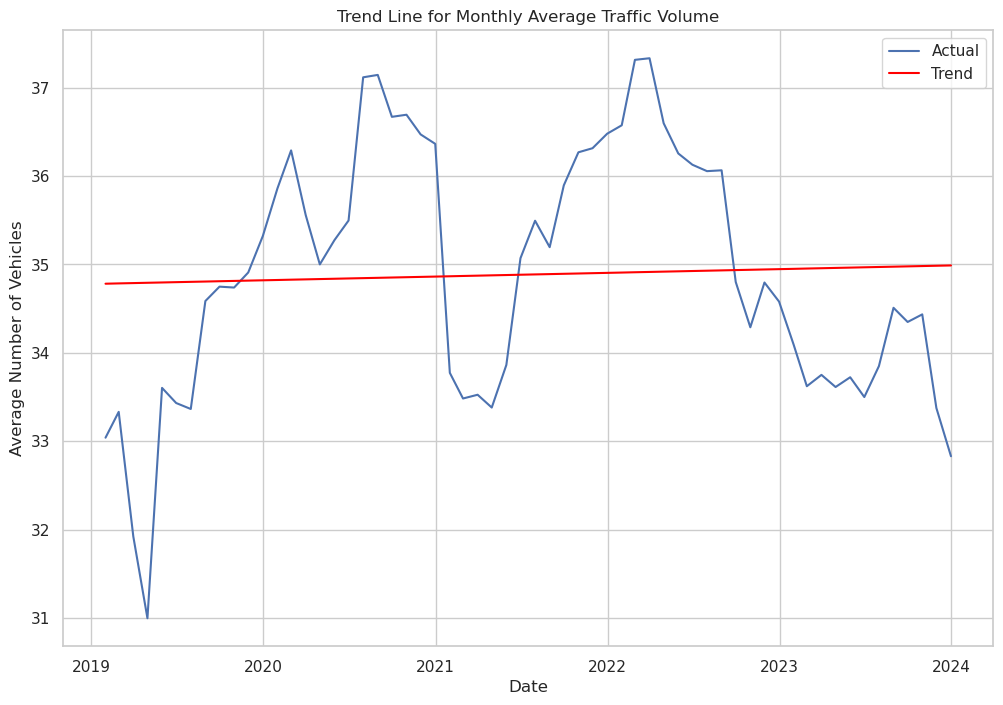

In [17]:
traffic_data = pd.read_csv('./datasets/traffic1.csv', sep=";")
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Resample the data to get monthly averages
traffic_data.set_index('DateTime', inplace=True)    #modifier l'index des données pour mettre la colonne DateTime
monthly_traffic = traffic_data.resample('M').mean()

# Plot the monthly traffic volume
monthly_traffic['Vehicles'].plot(title='Monthly Average Traffic Volume')
plt.ylabel('Average Number of Vehicles')
plt.show()

# Linear Regression for Trend Analysis

X = np.arange(len(monthly_traffic)).reshape(-1, 1)  # Time as an independent variable
y = monthly_traffic['Vehicles'].values  # Traffic volume as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the trend
plt.plot(monthly_traffic.index, y, label='Actual')
plt.plot(monthly_traffic.index, trend, label='Trend', color='red')
plt.title('Trend Line for Monthly Average Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Average Number of Vehicles')
plt.legend()
plt.show()

In [18]:
# Pour analyser les tendances à long terme, nous utiliserons les données de trafic quotidiennes moyennes rééchantillonnées que nous avons créées plus tôt

# Tout d'abord, vérifions si ces données sont toujours disponibles dans l'environnement.

# Vérifier si 'traffic_data_resampled' est disponible et imprimer les premières entrées
try:
    print(traffic_data_resampled.head())
except NameError:
    # If not, recreate it
    traffic_data_resampled = traffic_data.set_index('DateTime').resample('D').mean()['Vehicles']
    print(traffic_data_resampled.head())

            Junction   Vehicles
DateTime                       
2019-01-01  5.928571  31.428571
2019-01-02  5.692308  33.330128
2019-01-03  5.615385  32.217949
2019-01-04  5.615385  30.115385
2019-01-05  5.615385  32.461538


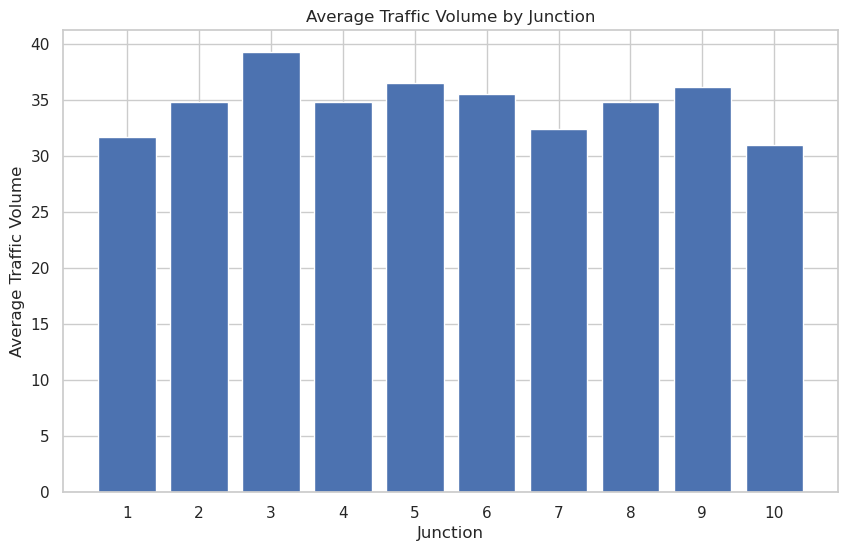

In [19]:
traffic_data = pd.read_csv('./datasets/traffic1.csv', sep=";")

# Convert 'DateTime' to a datetime object for easier manipulation
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Group the data by 'Junction' and calculate the average 'Vehicles'
junction_comparison = traffic_data.groupby('Junction')['Vehicles'].mean().reset_index()

# Plotting the average traffic volume by junction
plt.figure(figsize=(10, 6))
plt.bar(junction_comparison['Junction'], junction_comparison['Vehicles'])
plt.title('Average Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Average Traffic Volume')
plt.xticks(junction_comparison['Junction'])
plt.show()

In [20]:
avg_traffic_by_junction = traffic_data.groupby('Junction')['Vehicles'].mean()
avg_traffic_by_junction

Junction
1     31.675475
2     34.836368
3     39.250274
4     34.806645
5     36.512665
6     35.562938
7     32.399161
8     34.848850
9     36.112883
10    30.936827
Name: Vehicles, dtype: float64

In [21]:
# Set the 'DateTime' column as the index
traffic_data.set_index('DateTime', inplace=True)

# Resample the data by day to get the total number of vehicles per day
daily_traffic = traffic_data.resample('D').sum()

# Calculate the Z-scores for the daily traffic volume
daily_traffic['Z-Score'] = zscore(daily_traffic['Vehicles'])

# Define a threshold for identifying outliers
threshold = 2

# Identify outliers
outliers = daily_traffic[(daily_traffic['Z-Score'] > threshold) | (daily_traffic['Z-Score'] < -threshold)]

# Display the outliers
print(outliers)

            Junction  Vehicles   Z-Score
DateTime                                
2019-01-04      1752      9396 -2.369235
2019-01-13      1776      9351 -2.440807
2019-02-04      1752      9241 -2.615760
2019-03-01      1752      9383 -2.389911
2019-03-04      1752      9018 -2.970437
...              ...       ...       ...
2022-10-14      1752      9598 -2.047958
2023-06-12      1752      9356 -2.432854
2023-11-21      1752      9501 -2.202235
2023-12-27      1752      9483 -2.230863
2023-12-29      1752      9616 -2.019329

[69 rows x 3 columns]


In [22]:
# Check if 'DateTime' is already the index to avoid the KeyError


if not isinstance(traffic_data.index, pd.DatetimeIndex):
    traffic_data.set_index('DateTime', inplace=True)

# Now, resample the data by day to get the total number of vehicles per day
daily_traffic = traffic_data.resample('D').sum()

# Calculate the Z-scores for the daily traffic volume
daily_traffic['Z-Score'] = stats.zscore(daily_traffic['Vehicles'])    #valeur centrée réduite

# Define outliers as any data point that is more than 3 standard deviations from the mean
outliers = daily_traffic[np.abs(daily_traffic['Z-Score']) > 2]

# Display the outliers
outliers[['Vehicles', 'Z-Score']]

,Vehicles,Z-Score
DateTime,,
2019-01-04,9396,-2.369235
2019-01-13,9351,-2.440807
2019-02-04,9241,-2.615760
2019-03-01,9383,-2.389911
2019-03-04,9018,-2.970437
...,...,...
2022-10-14,9598,-2.047958
2023-06-12,9356,-2.432854
2023-11-21,9501,-2.202235


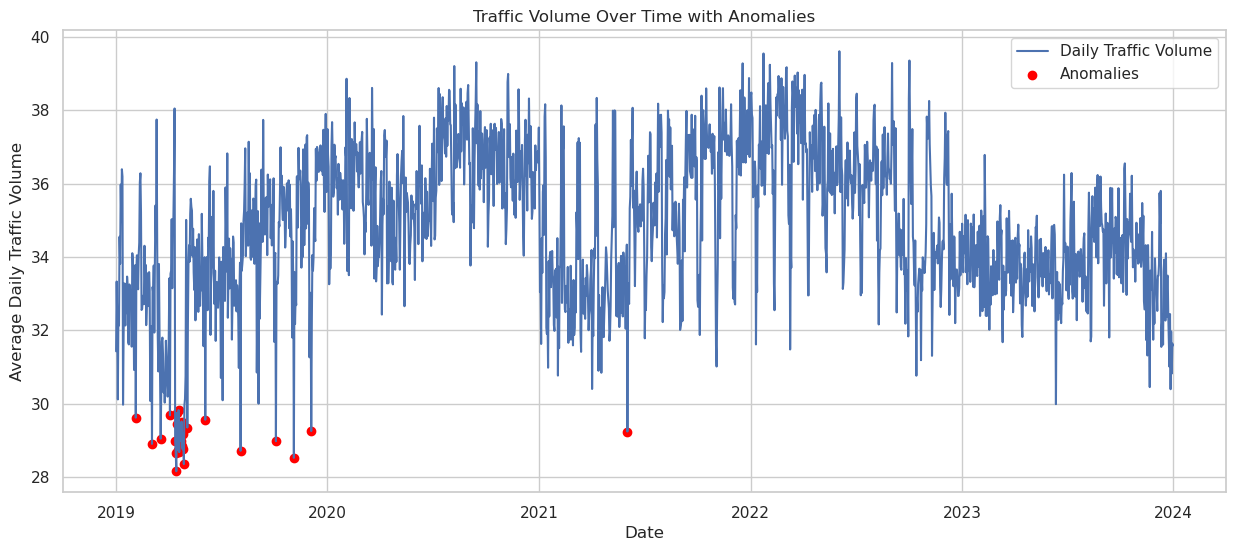

In [23]:
traffic_data = pd.read_csv('./datasets/traffic1.csv', sep=";")
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data_daily = traffic_data.set_index('DateTime').resample('D').mean()

# Calculate the Z-score for each day's traffic volume
traffic_data_daily['z_score'] = (traffic_data_daily['Vehicles'] - traffic_data_daily['Vehicles'].mean()) / traffic_data_daily['Vehicles'].std()

# Identify days where the Z-score is above a certain threshold (seuil) (e.g., 2 or -2 for significant anomalies)
anomalies = traffic_data_daily[abs(traffic_data_daily['z_score']) > 2.5]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(traffic_data_daily.index, traffic_data_daily['Vehicles'], label='Daily Traffic Volume')
plt.scatter(anomalies.index, anomalies['Vehicles'], color='red', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Average Daily Traffic Volume')
plt.title('Traffic Volume Over Time with Anomalies')
plt.legend()
plt.show()

In [24]:
traffic_data = pd.read_csv('./datasets/traffic1.csv', sep=";")
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data = traffic_data.sort_values(by='DateTime')

# Check for missing timestamps
expected_timestamps = pd.date_range(start=traffic_data['DateTime'].min(), 
                                    end=traffic_data['DateTime'].max(), 
                                    freq='H')
missing_timestamps = expected_timestamps.difference(traffic_data['DateTime'])

In [25]:
# Check the number of records per junction
records_per_junction = traffic_data['Junction'].value_counts()

# Check for irregular time intervals
time_diffs = traffic_data.groupby('Junction').apply(lambda x: x['DateTime'].diff().unique())

In [26]:
# Get the time range for each junction
time_range_per_junction = traffic_data.groupby('Junction')['DateTime'].agg(['min', 'max'])

In [27]:
# Detecting outliers in 'Vehicles' column
Q1 = traffic_data['Vehicles'].quantile(0.25)
Q3 = traffic_data['Vehicles'].quantile(0.75)
IQR = Q3 - Q1
outliers = traffic_data[(traffic_data['Vehicles'] < (Q1 - 1.5 * IQR)) | (traffic_data['Vehicles'] > (Q3 + 1.5 * IQR))]

Missing Timestamps:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Records per Junction:
6     174321
7      44799
4      44064
10     43848
1      43824
3      43824
8      43824
9      43824
2      43824
5      43584
Name: Junction, dtype: int64

Time Intervals:
Junction
1                      [NaT, 3600000000000 nanoseconds]
2                      [NaT, 3600000000000 nanoseconds]
3                      [NaT, 3600000000000 nanoseconds]
4       [NaT, 0 nanoseconds, 3600000000000 nanoseconds]
5     [NaT, 3600000000000 nanoseconds, 9000000000000...
6       [NaT, 0 nanoseconds, 3600000000000 nanoseconds]
7       [NaT, 0 nanoseconds, 3600000000000 nanoseconds]
8                      [NaT, 3600000000000 nanoseconds]
9                      [NaT, 3600000000000 nanoseconds]
10      [NaT, 0 nanoseconds, 3600000000000 nanoseconds]
dtype: object

Time Range for Each Junction:
                min                 max
Junction                               
1        2019-01-01 2023-12-31 23:

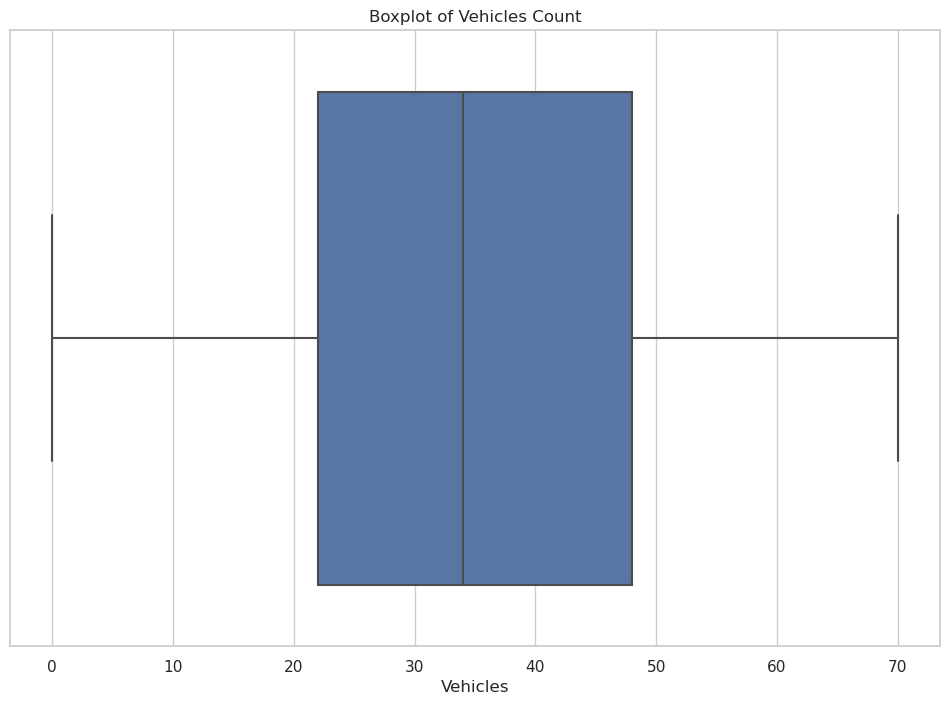

In [28]:
# Step 1: Print Missing Timestamps
print("Missing Timestamps:")
print(missing_timestamps)

# Step 2: Print Records Per Junction and Time Intervals
print("\nRecords per Junction:")
print(records_per_junction)
print("\nTime Intervals:")
print(time_diffs)

# Step 3: Print Time Range for Each Junction
print("\nTime Range for Each Junction:")
print(time_range_per_junction)

# Step 4: Print and Visualize Outliers
print("\nOutliers in Vehicle Counts:")
print(outliers)

# Visualizing Outliers with a Boxplot
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=traffic_data['Vehicles'])
plt.title('Boxplot of Vehicles Count')
plt.show()

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Read the traffic data
traffic_data = pd.read_csv('./datasets/traffic1.csv', sep=";")

# Feature Engineering
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['HourOfDay'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek

# Encode categorical variable 'Junction'
traffic_data = pd.get_dummies(traffic_data, columns=['Junction'], drop_first=True)

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_2', 'Junction_3', 'Junction_4']
target = 'Vehicles'

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_data, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(train_data[features], train_data[target])

# Model Prediction
predictions = model.predict(test_data[features])

# Model Evaluation
mae = mean_absolute_error(test_data[target], predictions)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 12.813927752109988


In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assume 'traffic_data' is your DataFrame

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_2', 'Junction_3', 'Junction_4','Junction_5', 'Junction_6', 'Junction_7']
target = 'Vehicles'

# Set a threshold to classify as high or low traffic
threshold = 25  # You can adjust this threshold based on your problem

# Create a binary target variable
traffic_data['TrafficLevel'] = (traffic_data[target] > threshold).astype(int)

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_data, test_size=0.3, random_state=42)

# Separate features and target in the training and testing sets
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']

# Train a random forest classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
classification_report_str = classification_report(y_test, predictions)

# Print the metrics
print(f'Accuracy: {accuracy:.2%}')
print('Classification Report:')
print(classification_report_str)

Accuracy: 68.18%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     54384
           1       0.68      1.00      0.81    116537

    accuracy                           0.68    170921
   macro avg       0.34      0.50      0.41    170921
weighted avg       0.46      0.68      0.55    170921



In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assume 'traffic_data' is your DataFrame

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_2', 'Junction_3', 'Junction_4','Junction_5', 'Junction_6', 'Junction_7']
target = 'Vehicles'

# Set a threshold to classify as high or low traffic
threshold = 35  # You can adjust this threshold based on your problem

# Create a binary target variable
traffic_data['TrafficLevel'] = (traffic_data[target] > threshold).astype(int)

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_data, test_size=0.3, random_state=50)

# Separate features and target in the training and testing sets
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']

# Train a random forest classifier
classifier = RandomForestClassifier(random_state=50)
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
classification_report_str = classification_report(y_test, predictions)

# Print the metrics
print(f'Accuracy: {accuracy:.2%}')
print('Classification Report:')
print(classification_report_str)

Accuracy: 53.53%
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.69      0.61     89091
           1       0.52      0.37      0.43     81830

    accuracy                           0.54    170921
   macro avg       0.53      0.53      0.52    170921
weighted avg       0.53      0.54      0.52    170921



In [36]:
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier

# Assume 'classifier' is your trained RandomForestClassifier
# Assume 'features' is a list of feature names used in training the model

def predict_traffic_level(input_date, hour_of_day, junction):
    # Convert input_date to a datetime object
    input_datetime = datetime.strptime(input_date, '%Y-%m-%d %H:%M:%S')
    
    # Determine the day of the week (Monday is 0, Sunday is 6)
    day_of_week = input_datetime.weekday()
    
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'HourOfDay': [hour_of_day],
        'DayOfWeek': [day_of_week],
        'Junction_2': [1 if junction == 2 else 0],
        'Junction_3': [1 if junction == 3 else 0],
        'Junction_4': [1 if junction == 4 else 0],
        'Junction_5': [1 if junction == 5 else 0],
        'Junction_6': [1 if junction == 6 else 0],
        'Junction_7': [1 if junction == 7 else 0]
    })
    
    # Make a prediction using the trained classifier
    traffic_level = classifier.predict(input_data[features])[0]
    
    # Interpret the predicted traffic level
    if traffic_level == 0:
        return 'Low Traffic'
    elif traffic_level == 1:
        return 'High Traffic'
    else:
        return 'Unknown'

# Example usage
input_date = '2023-01-01 14:00:00'
hour = 14  # Example hour of the day
junction = 1  # Example junction

predicted_traffic_level = predict_traffic_level(input_date, hour, junction)
print(f'Predicted Traffic Level: {predicted_traffic_level}')


Predicted Traffic Level: High Traffic


In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assume 'traffic_data' is your DataFrame

# Define features and target
features = ['HourOfDay', 'DayOfWeek', 'Junction_2', 'Junction_3', 'Junction_4', 'Junction_5', 'Junction_6', 'Junction_7']
target = 'Vehicles'

# Set a threshold to classify as high or low traffic
threshold = 30  # You can adjust this threshold based on your problem

# Create a binary target variable
traffic_data['TrafficLevel'] = (traffic_data[target] > threshold).astype(int)

# Split the data into training and testing sets
train_data, test_data = train_test_split(traffic_data, test_size=0.4, random_state=50)

# Separate features and target in the training and testing sets
X_train, y_train = train_data[features], train_data['TrafficLevel']
X_test, y_test = test_data[features], test_data['TrafficLevel']

# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_classification_report = classification_report(y_test, dt_predictions)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

# Train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_classification_report = classification_report(y_test, svm_predictions)

# Train a k-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_classification_report = classification_report(y_test, knn_predictions)

# Train a Logistic Regression classifier
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_classification_report = classification_report(y_test, lr_predictions)

# Train a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
gb_predictions = gb_classifier.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_classification_report = classification_report(y_test, gb_predictions)

# Print the metrics for each classifier
print('Decision Tree Classifier:')
print(f'Accuracy: {dt_accuracy:.2%}')
print('Classification Report:')
print(dt_classification_report)

print('\nRandom Forest Classifier:')
print(f'Accuracy: {rf_accuracy:.2%}')
print('Classification Report:')
print(rf_classification_report)

print('\nSupport Vector Machine (SVM) Classifier:')
print(f'Accuracy: {svm_accuracy:.2%}')
print('Classification Report:')
print(svm_classification_report)

print('\nk-Nearest Neighbors (KNN) Classifier:')
print(f'Accuracy: {knn_accuracy:.2%}')
print('Classification Report:')
print(knn_classification_report)

print('\nLogistic Regression Classifier:')
print(f'Accuracy: {lr_accuracy:.2%}')
print('Classification Report:')
print(lr_classification_report)

print('\nGradient Boosting Classifier:')
print(f'Accuracy: {gb_accuracy:.2%}')
print('Classification Report:')
print(gb_classification_report)

Decision Tree Classifier:
Accuracy: 57.05%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.06      0.11     72660
           1       0.58      0.95      0.72     98261

    accuracy                           0.57    170921
   macro avg       0.52      0.50      0.41    170921
weighted avg       0.53      0.57      0.46    170921


Random Forest Classifier:
Accuracy: 57.08%
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.06      0.11     72660
           1       0.58      0.95      0.72     98261

    accuracy                           0.57    170921
   macro avg       0.52      0.50      0.41    170921
weighted avg       0.53      0.57      0.46    170921


Support Vector Machine (SVM) Classifier:
Accuracy: 57.49%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     72660
           1       0.5